In [ ]:
!pip install --upgrade segments-ai

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from segments import SegmentsClient
import json
import pandas as pd
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
with open('/content/drive/MyDrive/Thesis: Cannabis maturity assessment project/patches_segments.pickle', 'rb') as f:
    SAM_data = pickle.load(f)

In [15]:
SAM_data.keys()

dict_keys(['name', 'masks', 'num_segments'])

In [10]:
# You can find your api key at https://segments.ai/account
api_key = "e022f204199f265634b16cf18485bdd53cb7becf"
client = SegmentsClient(api_key)
dataset = 'etaylor/trichomes_moment_lens_instance_segmentation'
sample = client.get_samples(dataset)

In [23]:
def get_ground_truth(index, dataset):
    sample = client.get_samples(dataset)[index]
    label = client.get_label(sample.uuid, labelset='ground-truth')
    total = len(label.attributes.annotations)
    # Load the labels as numpy arrays
    image = load_image_from_url(sample.attributes.image.url)
    instance_bitmap = get_semantic_bitmap(label.attributes.segmentation_bitmap.url)
    semantic_bitmap = get_semantic_bitmap(instance_bitmap, label.attributes.annotations)
    return image, instance_bitmap, total, sample.name

def build_ground_truth_dict(dataset):
    ground_truth_dict = {}
    num_samples = len(client.get_samples(dataset))

    for i in range(num_samples):
        image, instance_bitmap, total, name = get_ground_truth(i, dataset)
        name = name.split('.')[0]
        ground_truth_dict[name] = {
            'image': image,
            'instance_bitmap': instance_bitmap,
            'total_annotations': total,
        }

    return ground_truth_dict

def build_segmentation_dict(segmentation_result_dict):
    segmentation_dict = {}

    for name, mask, num in zip(segmentation_result_dict['name'], 
                               segmentation_result_dict['masks'], 
                               segmentation_result_dict['num_segments']):
        segmentation_dict[name] = {
            'mask': mask,
            'num_segments': num,
        }

    return segmentation_dict

In [24]:
SAM_dict = build_segmentation_dict(SAM_data)
ground_truth_dict = build_ground_truth_dict(dataset)

## Measure SAM scores

In [19]:
# regression score
def measure_count_metrics(ground_truth, prediction):
    # Initialize sum of errors
    abs_error_sum = 0
    sq_error_sum = 0
    total_samples = len(ground_truth)

    for name in ground_truth:
        true_count = ground_truth[name]['total_annotations']
        predicted_count = prediction[name]['num_segments']

        abs_error_sum += abs(predicted_count - true_count)
        sq_error_sum += (predicted_count - true_count) ** 2

    # Calculate metrics
    mae = abs_error_sum / total_samples
    mse = sq_error_sum / total_samples

    return {
        'MAE': mae,
        'MSE': mse
    }

In [26]:
regression_scores_dict = measure_count_metrics(ground_truth_dict, SAM_dict)

In [27]:
regression_scores_dict

{'MAE': 41.03921568627451, 'MSE': 1920.8431372549019}

In [38]:
mae_list = []
mse_list = []
samples_name = []

for name in ground_truth_dict:
    true_count = ground_truth_dict[name]['total_annotations']
    predicted_count = SAM_dict[name]['num_segments']

    mae = abs(predicted_count - true_count)
    mse = (predicted_count - true_count) ** 2

    mae_list.append(mae)
    mse_list.append(mse)
    samples_name.append(name)

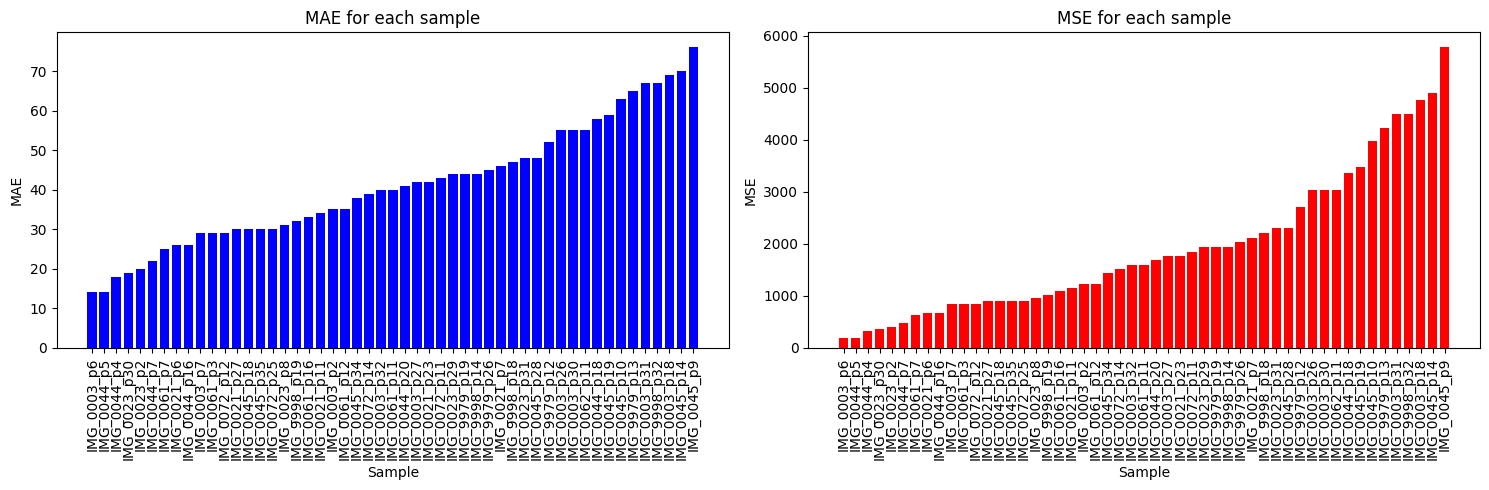

In [41]:

# Create a list of tuples and sort it
mae_tuples = sorted(zip(mae_list, samples_name))
mse_tuples = sorted(zip(mse_list, samples_name))

# Unzip the sorted tuples
mae_list_sorted, samples_name_mae_sorted = zip(*mae_tuples)
mse_list_sorted, samples_name_mse_sorted = zip(*mse_tuples)

plt.figure(figsize=(15,5))

# Plot MAE
plt.subplot(1, 2, 1)
plt.bar(samples_name_mae_sorted, mae_list_sorted, color='blue')
plt.title('MAE for each sample')
plt.xlabel('Sample')
plt.ylabel('MAE')
plt.xticks(rotation='vertical')

# Plot MSE
plt.subplot(1, 2, 2)
plt.bar(samples_name_mse_sorted, mse_list_sorted, color='red')
plt.title('MSE for each sample')
plt.xlabel('Sample')
plt.ylabel('MSE')
plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

## Measure Segmentaiton Scores

In [32]:
def calculate_segmentation_scores(prediction_mask, ground_truth_mask):
    # Convert to numpy arrays
    prediction_mask = np.array(prediction_mask)
    ground_truth_mask = np.array(ground_truth_mask)

    # Convert to binary masks
    prediction_mask = prediction_mask > 0
    ground_truth_mask = ground_truth_mask > 0

    # Calculate intersection and union
    intersection = np.logical_and(prediction_mask, ground_truth_mask)
    union = np.logical_or(prediction_mask, ground_truth_mask)

    # Calculate IoU
    iou_score = np.sum(intersection) / np.sum(union)

    # Calculate Dice Coefficient
    dice_score = 2 * np.sum(intersection) / (np.sum(prediction_mask) + np.sum(ground_truth_mask))

    # Calculate Pixel Accuracy
    correct_pixels = np.sum(prediction_mask == ground_truth_mask)
    total_pixels = np.size(prediction_mask)
    pixel_accuracy = correct_pixels / total_pixels

    return iou_score, dice_score, pixel_accuracy

In [ ]:
iou_scores = []
dice_scores = []
pixel_accuracies = []

for name in ground_truth_dict:
    iou_score, dice_score, pixel_accuracy = calculate_segmentation_scores(SAM_dict[name]['mask'], ground_truth_dict[name]['instance_bitmap'])
    iou_scores.append(iou_score)
    dice_scores.append(dice_score)
    pixel_accuracies.append(pixel_accuracy)

average_iou = np.mean(iou_scores)
average_dice = np.mean(dice_scores)
average_pixel_accuracy = np.mean(pixel_accuracies)

In [34]:
SAM_dict.keys()

dict_keys(['IMG_0062_p11', 'IMG_0072_p14', 'IMG_0072_p11', 'IMG_0072_p12', 'IMG_0072_p25', 'IMG_9979_p26', 'IMG_9979_p13', 'IMG_9979_p12', 'IMG_9979_p19', 'IMG_0021_p6', 'IMG_0021_p7', 'IMG_0021_p27', 'IMG_0021_p11', 'IMG_9998_p14', 'IMG_9998_p19', 'IMG_9998_p32', 'IMG_9998_p18', 'IMG_0045_p19', 'IMG_0021_p23', 'IMG_0045_p9', 'IMG_0045_p18', 'IMG_0045_p28', 'IMG_0045_p10', 'IMG_0045_p35', 'IMG_0045_p34', 'IMG_0045_p14', 'IMG_0061_p16', 'IMG_0061_p12', 'IMG_0061_p11', 'IMG_0061_p7', 'IMG_0061_p3', 'IMG_0003_p26', 'IMG_0003_p27', 'IMG_0003_p30', 'IMG_0003_p32', 'IMG_0003_p18', 'IMG_0003_p31', 'IMG_0003_p2', 'IMG_0003_p7', 'IMG_0003_p6', 'IMG_0044_p18', 'IMG_0044_p4', 'IMG_0044_p5', 'IMG_0044_p20', 'IMG_0044_p16', 'IMG_0044_p7', 'IMG_0023_p29', 'IMG_0023_p30', 'IMG_0023_p2', 'IMG_0023_p31', 'IMG_0023_p8'])

In [36]:
SAM_dict['IMG_0062_p11']['mask']

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 2352,
  'bbox': [325, 162, 72, 47],
  'predicted_iou': 1.0128952264785767,
  'point_coords': [[367.1875, 179.6875]],
  'stability_score': 0.9776936173439026,
  'crop_box': [0, 0, 500, 500]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 2718,
  'bbox': [207, 202, 52